In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import boxcox
import joblib

In [2]:
df = pd.read_csv('analyzed_data.csv')
y = df.calories_burned
x = df.drop('calories_burned', axis=1)
sc_x = pd.DataFrame(StandardScaler().fit_transform(x), columns = x.columns)

In [3]:
def alg_evaluation(x, y):

    alg_dict = {'lr': LinearRegression(),
                'tree': DecisionTreeRegressor(),
                'rf': RandomForestRegressor(),
                'gb': GradientBoostingRegressor(),
                'svm': SVR(),
                'xgb': XGBRegressor()}

    alg_list = ['lr', 'tree', 'rf', 'gb', 'svm', 'xgb']
    cv_score_list = []

    for alg in alg_list:
        rm = alg_dict[alg]
        cv_score = cross_val_score(rm, x, y, cv=5)
        cv_score_list.append(cv_score.mean())

    eval_df = pd.DataFrame({'algorithm': alg_list, 'mean_rsq': cv_score_list})
    eval_df = eval_df.sort_values(by = 'mean_rsq', ascending = False).reset_index(drop = True)
    return(eval_df)

In [4]:
alg_evaluation(sc_x, y)

,algorithm,mean_rsq
0,gb,0.994029
1,xgb,0.987388
2,lr,0.978364
3,rf,0.977450
4,tree,0.941269
5,svm,0.225001


In [5]:
def transform_y (transformation, y, type, lamb=0):
    
    import numpy as np

    if type == 'direct':
        if transformation == 'log':
            trans_y = np.log(y)
            return(trans_y)
        elif transformation == 'sqrt':
            trans_y = np.sqrt(y)
            return(trans_y)
        elif transformation == 'boxcox':
            if lamb == 0:
                print('Missing argument: lambda')
            else:
                trans_y = (y**lamb-1)/lamb
                return(trans_y)
        else:
            print('Applicable transformations: log, sqrt, boxcox')
    elif type == 'inverse':
        if transformation == 'log':
            trans_y = np.exp(y)
            return(trans_y)
        elif transformation == 'sqrt':
            trans_y = y**2
            return(trans_y)
        elif transformation == 'boxcox':
            if lamb == 0:
                print('Missing Argument: lambda')
            else:
                trans_y = (lamb*y + 1)**(1/lamb)
                return(trans_y)
        else:
            print('Applicable transformations: log, sqrt, boxcox')
    else:
        print('Applicable types: direct, inverse')

In [6]:
def trans_evaluation(x, y, model):

    rm = model
    lamb = boxcox(y)[1]
    trans_list = ['base', 'sqrt', 'log', 'boxcox']
    cv_score_list = []

    for trans in trans_list:
        if trans == 'base':
            cv_score = cross_val_score(rm, x, y, cv=5)
            cv_score_list.append(cv_score.mean())
        else:
            trans_y = transform_y(trans, y, 'direct', lamb)
            yhat = cross_val_predict(rm, x, trans_y, cv=5)
            yhat = transform_y(trans, yhat, 'inverse', lamb)
            cv_score_list.append(r2_score(y, yhat))

    eval_df = pd.DataFrame({'transformation': trans_list, 'mean_rsq': cv_score_list})
    eval_df = eval_df.sort_values(by = 'mean_rsq', ascending = False).reset_index(drop = True)
    return(eval_df)

In [7]:
rm = GradientBoostingRegressor()
trans_evaluation(x, y, rm)

,transformation,mean_rsq
0,boxcox,0.994666
1,log,0.994287
2,base,0.994081
3,sqrt,0.993980


In [10]:
def train_test_evaluation(x, y, model, n_rounds, transformation = 'base'):
    
    rm = model
    lamb = boxcox(y)[1]
    base_rmse = y.std()
    if transformation != 'base': y = transform_y(transformation, y, 'direct', lamb)
    rsq_list = []
    rrmse_list = []

    for i in range(n_rounds):
        tr_x, te_x, tr_y, te_y = train_test_split(x, y, test_size = 0.25)
        rm.fit(tr_x, tr_y)
        yhat = rm.predict(te_x)
        
        if transformation != 'base':
            te_y = transform_y(transformation, te_y, 'inverse', lamb)
            yhat = transform_y(transformation, yhat, 'inverse', lamb)
            
        rrmse = np.sqrt(mean_squared_error(te_y, yhat))/base_rmse
        rsq = r2_score(te_y, yhat)
        rrmse_list.append(rrmse)
        rsq_list.append(rsq)

    eval_df = pd.DataFrame({'RRMSE': rrmse_list, 'RSQ': rsq_list})
    return(eval_df.describe())

In [11]:
train_test_evaluation(x, y, rm, 10)

,RRMSE,RSQ
count,10.000000,10.000000
mean,0.080611,0.993537
std,0.006309,0.001085
min,0.072733,0.991545
25%,0.076393,0.993162
50%,0.080249,0.993475
75%,0.082485,0.994408
max,0.094959,0.994995


In [9]:
yhat = cross_val_predict(rm, x, y, cv=5)
resid = y - yhat
print('RRMSE: ', np.sqrt(mean_squared_error(y, yhat))/y.std())
print('RSQ: ', r2_score(y, yhat))

RRMSE:  0.07668476233082615
RSQ:  0.9941133972748514


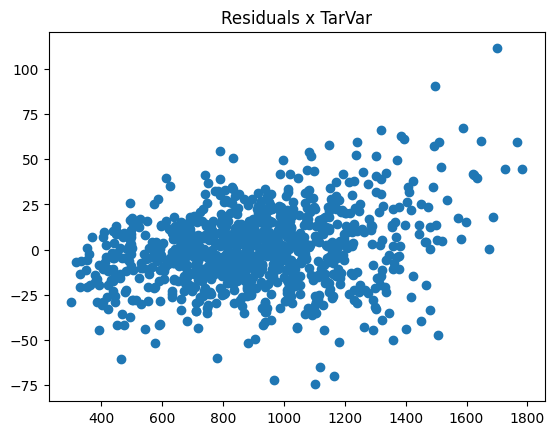

In [12]:
plt.scatter(y, resid)
plt.title('Residuals x TarVar')
plt.show()

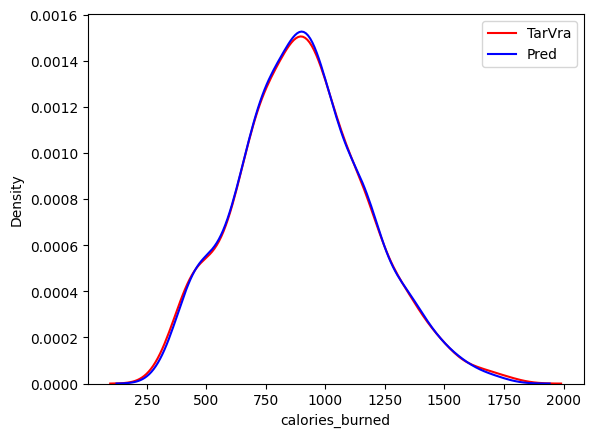

In [13]:
sns.kdeplot(y, color='red')
sns.kdeplot(yhat, color='blue')
plt.legend(['TarVra', 'Pred'])
plt.show()

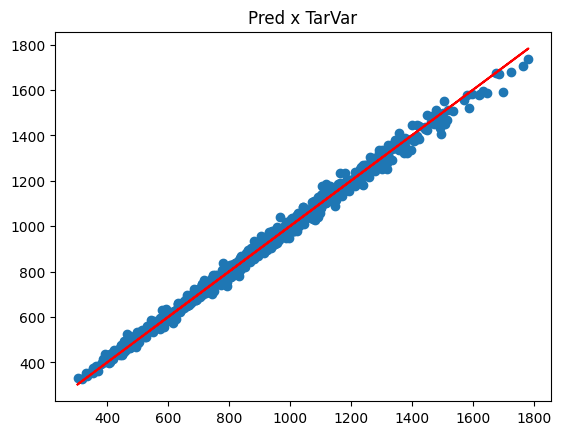

In [14]:
plt.scatter(y, yhat)
plt.plot(y, y, color='red')
plt.title('Pred x TarVar')
plt.show()

In [15]:
final_model = GradientBoostingRegressor().fit(x, y)
joblib.dump(final_model, 'final_model.pkl')

['final_model.pkl']